# Exoplanet Hunter

When a planet passes in between its star and us on Earth, there's a dip in the star's luminous flux (measure of the perceived power of light). Much like putting your hand between your eyes and the Sun. This can measured. We look for cyclic dips in the star's luminous flux. This is a sign that a planet is orbiting the star. This is how we hunt for exoplanets.

![alt text](http://www.nasa.gov/sites/default/files/thumbnails/image/heic1312a.jpg "Exoplanet")

### Dateset
We'll use a dataset provided by Kaggle (https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data). There's 37 confirmed exoplanet-stars and 5050 non-exoplanet-stars in the training set. And 5 confirmed exoplanet-stars and 565 non-exoplanet-stars in the test set.

The data was cleaned and derived from observations made by the NASA Kepler space telescope. 99% of the Kaggle dataset originates from Campaign 3. To boost the number of exoplanet-stars in the dataset, Kaggle included additional confirmed exoplanets from other campaigns.

**Column 1**
* Binary "LABEL" column
* '2' means the star has at least one exoplanet in its orbit (some stars have a multi-planet system)
* '1' means the star does not have an exoplanet

**Columns 2 through 3198**
* Flux values over time

### Setup

Import Python modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
from imblearn.over_sampling import RandomOverSampler
from scipy.signal import medfilt
import seaborn as sns
import matplotlib.pyplot as plt
import json

Load custom theme

In [2]:
with open('theme.json') as js:
     custom_style = json.load(js)
sns.set(font_scale=1.7, style='darkgrid', rc=custom_style)

### Exploring the Data

Import data first training set

In [3]:
train1 = pd.read_csv('./data/train_1.csv')

The first 37 rows are stars with exoplanets (Label = 2)

In [4]:
exo1 = train1[train1.LABEL == 2].drop(['Unnamed: 0', 'LABEL'], axis=1)
exo1.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [5]:
exo1.shape

(37, 3197)

There are 37 stars in this data frame with exoplanets. This agrees with the training set's description. Each star has 3,197 luminous flux measurements at different times. What is the time between flux measurements?

In [6]:
def plot_star(data):
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(data)),
                data,
                marker='.')
    plt.xlabel('Time')
    plt.ylabel('Light Flux')
    plt.show()

In [7]:
def plot_stars(data1, data2):
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(data1)),
                data1,
                marker='.',
                color='b',
                alpha=0.4,
                label='Original')
    plt.scatter(range(len(data2)),
                data2,
                marker='.',
                color='r',
                alpha=0.4,
                label='Modified')
    plt.xlabel('Time')
    plt.ylabel('Light Flux')
    plt.legend(loc='upper left')
    plt.show()

Plots a light flux over time of stars with exoplanets

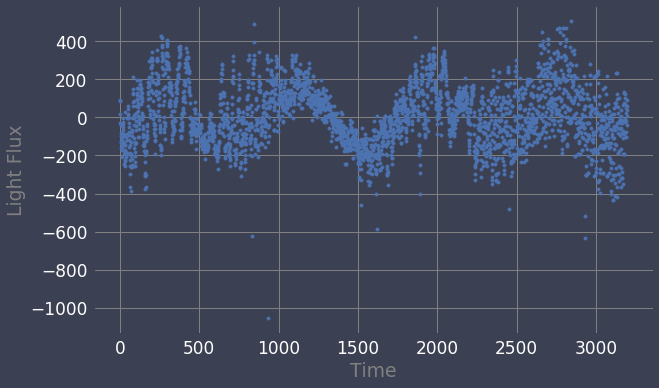

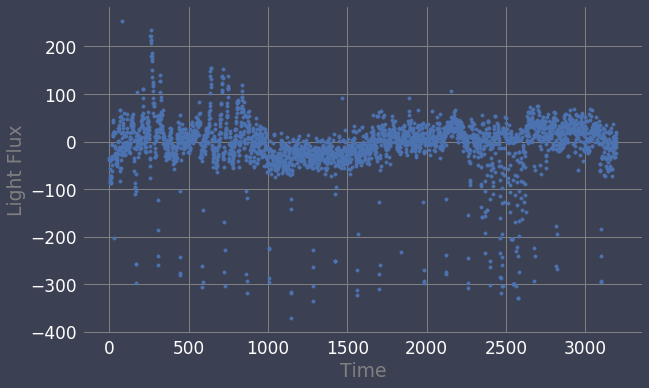

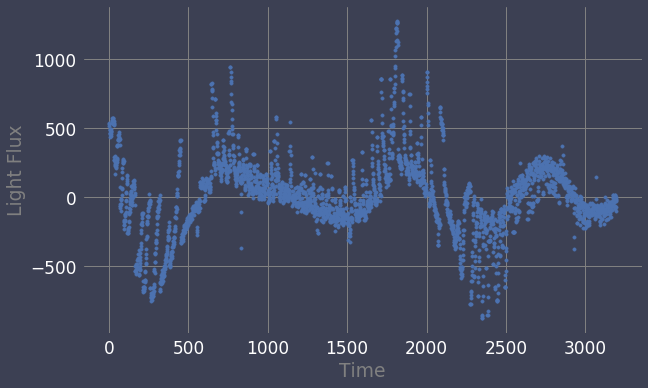

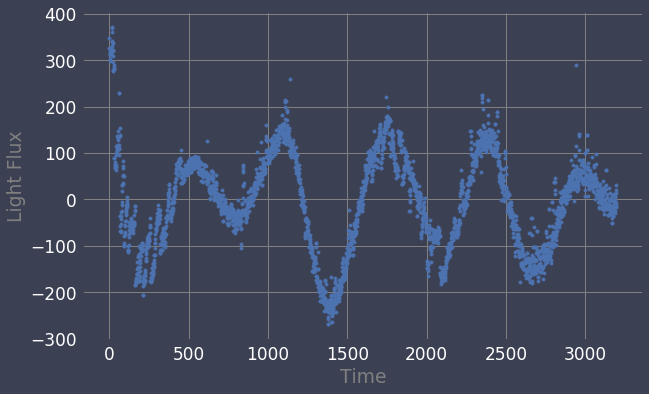

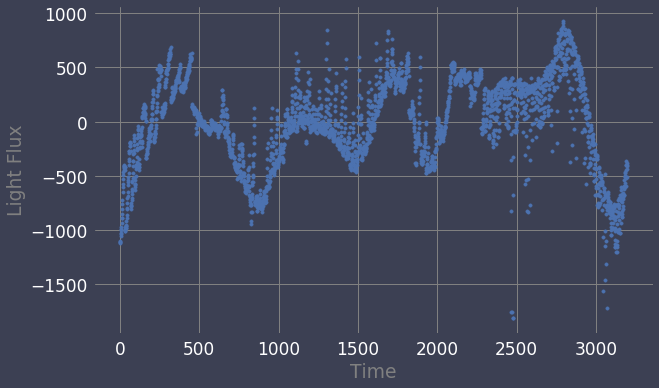

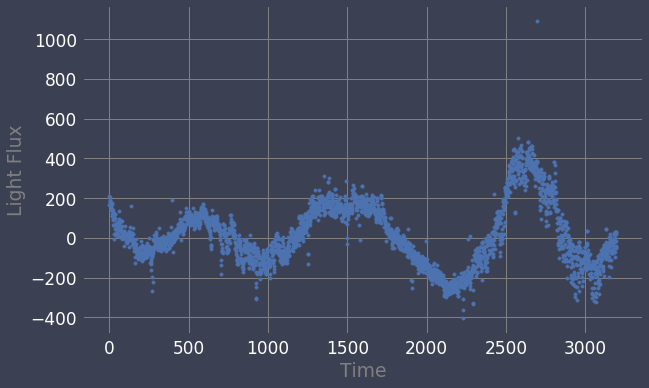

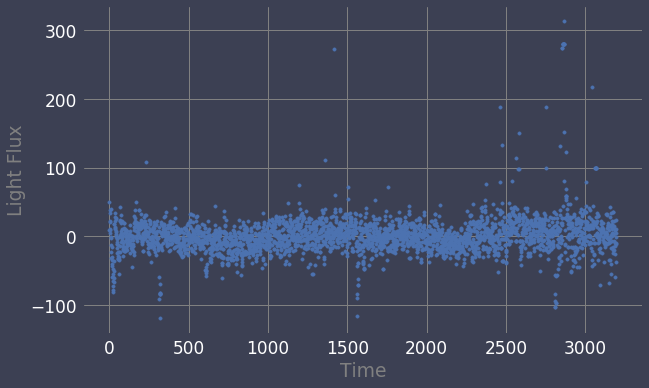

In [8]:
for i in range(7):
    plot_star(exo1.iloc[i])

Messy and noisy. I was expecting plots like "Exoplanet 7".

Let's "zoom in" on each graph

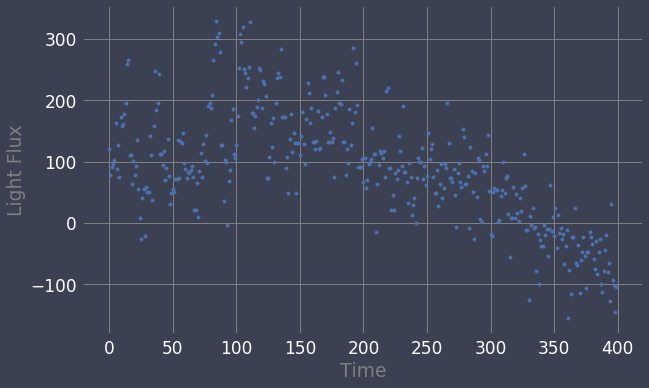

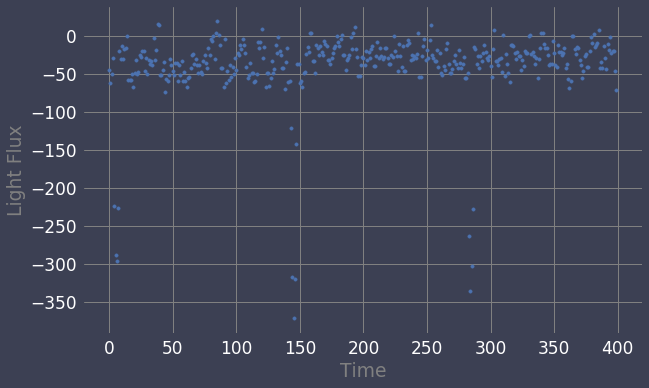

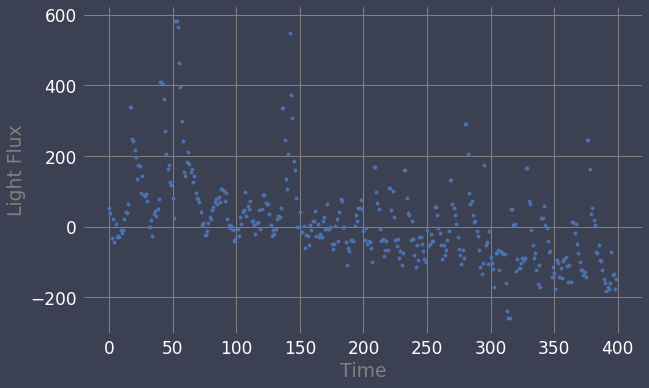

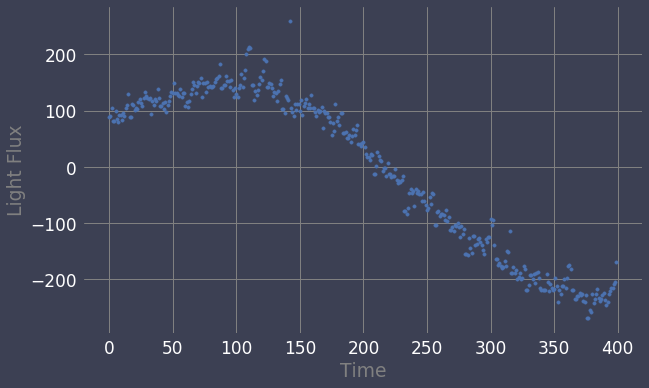

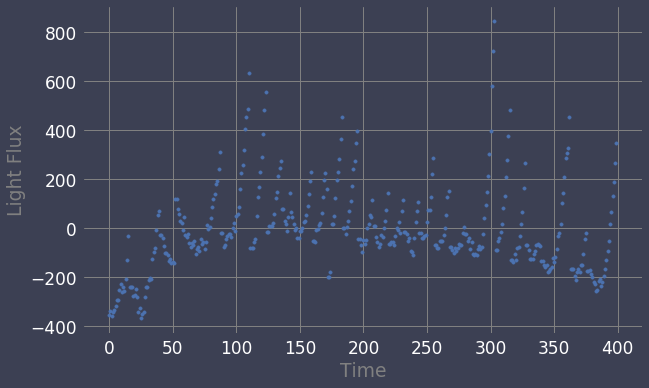

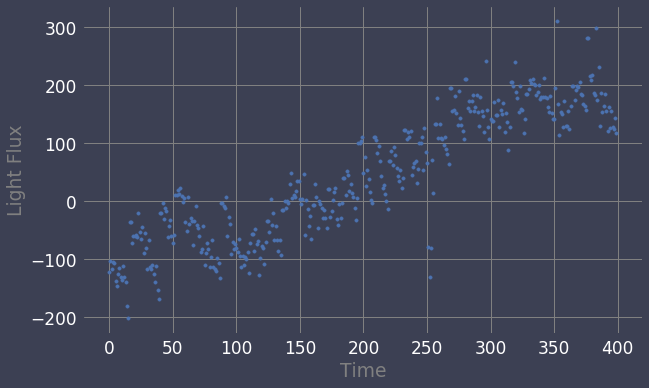

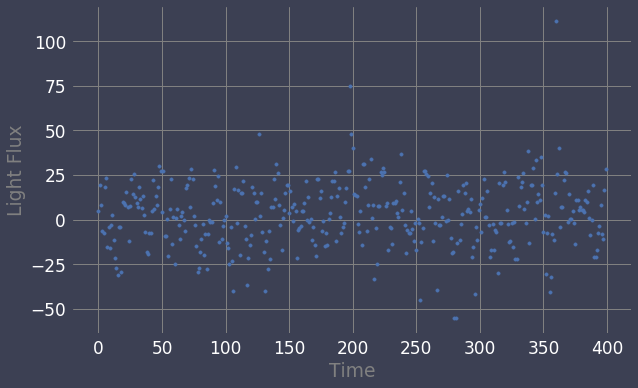

In [9]:
for i in range(7):
    plot_star(exo1.iloc[i, 1000:1400])

Cool "micro" patterns. These graphs help with setting the smoothing parameters.

### Smoothing

In [10]:
# Remove long-term trends
def remove_trend(data, window):
    return data - medfilt(data, window)

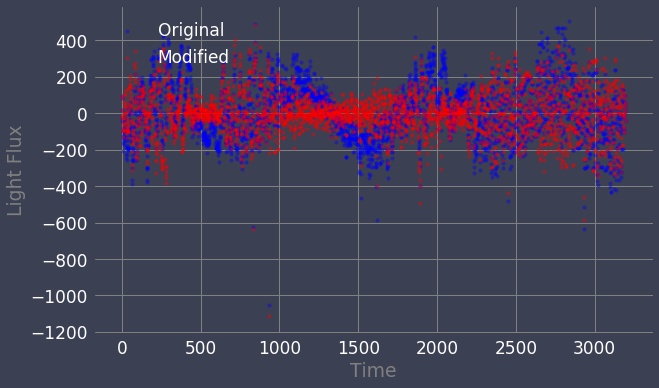

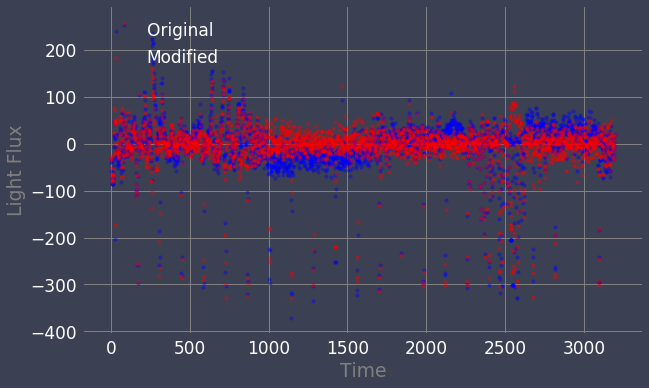

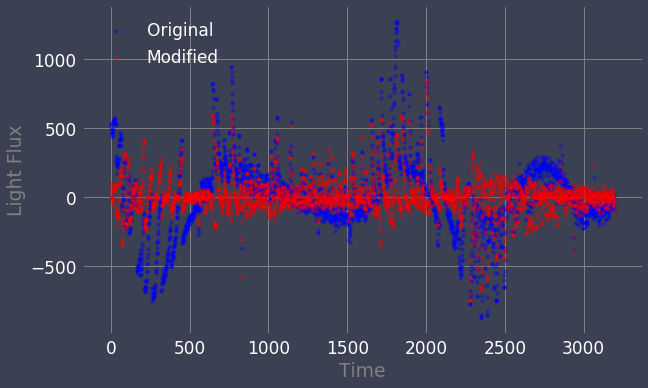

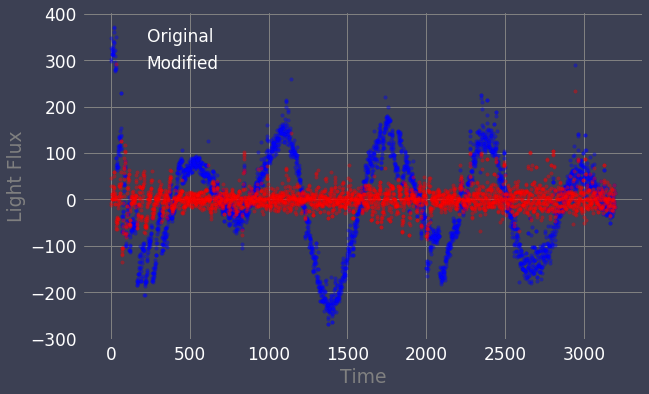

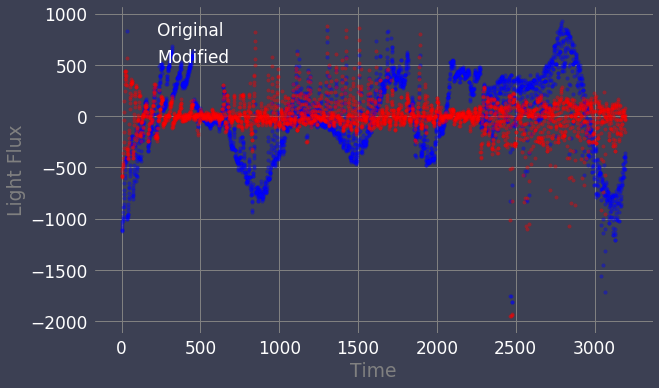

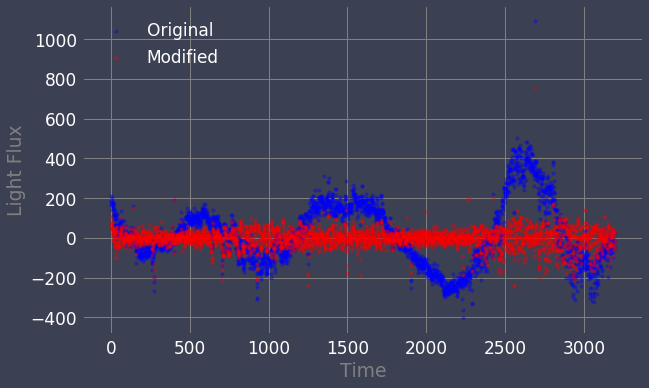

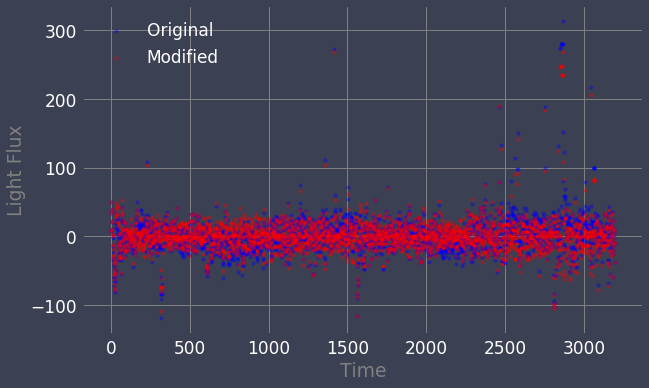

In [11]:
for i in range(7):
    plot_stars(exo1.iloc[i],
               remove_trend(exo1.iloc[i], 41))

Data is centered, but still noisy. And it appears the instrument's sensitivity was increased after time 2,300. Light dips are both down and up. This is getting complicated.

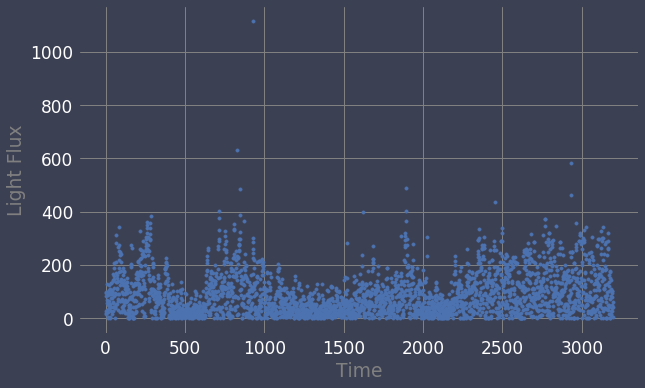

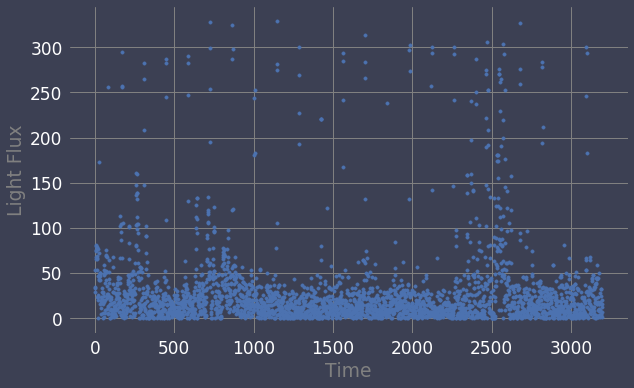

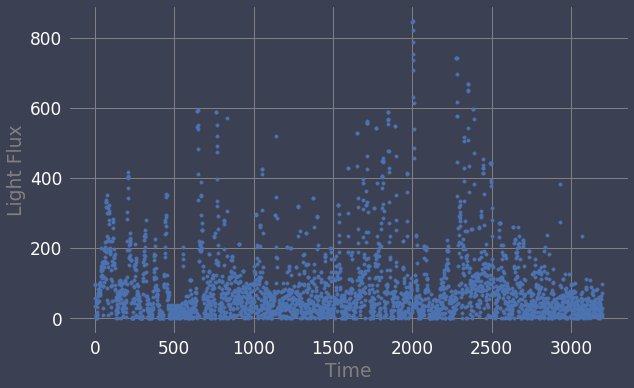

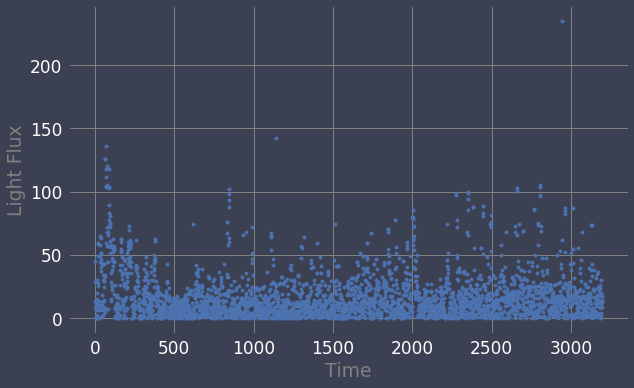

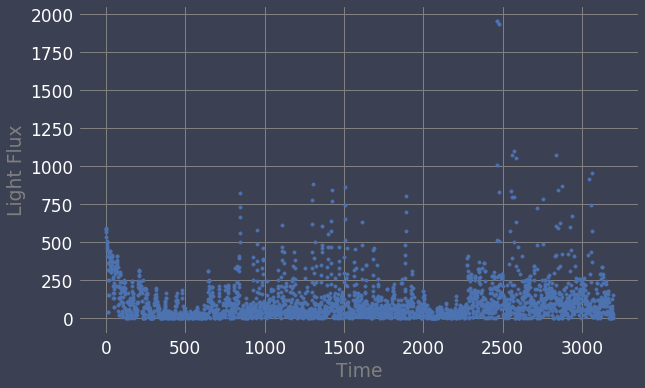

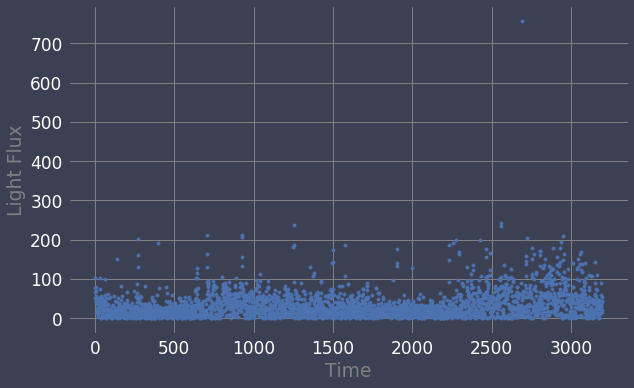

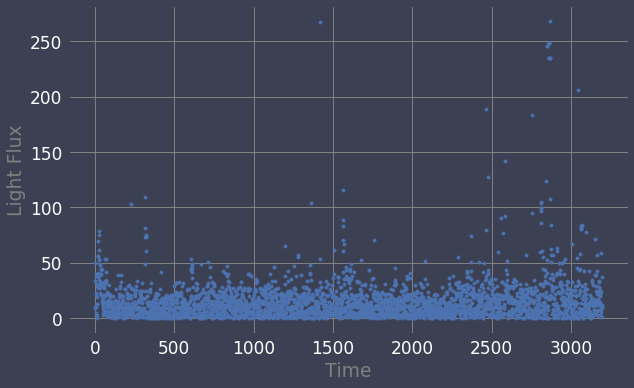

In [12]:
# Changing negatives into positives
for i in range(7):
    plot_star(np.abs(remove_trend(exo1.iloc[i], 41)))

The pattern becomes clearer. Still noisy. It's annoying how the variance can change in different sections of the data.

### Feature Engineering

What's the distribution of light flux after centering data?

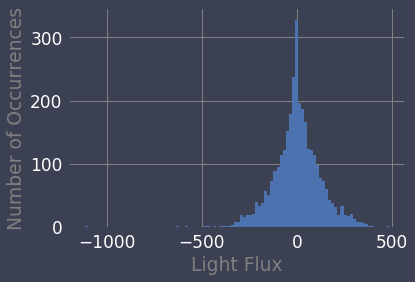

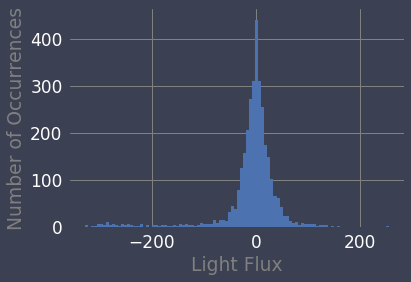

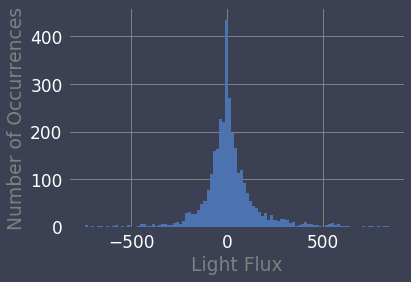

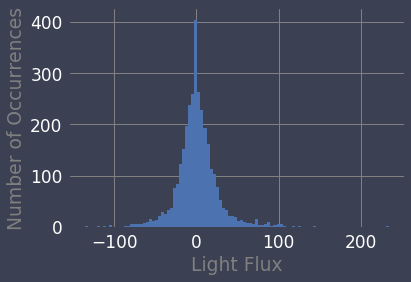

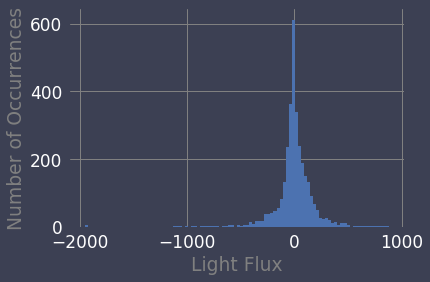

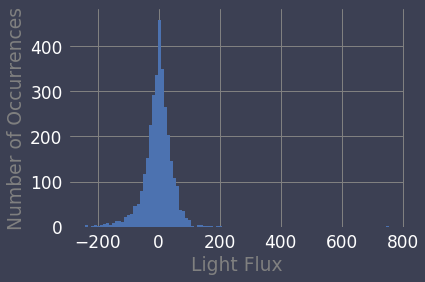

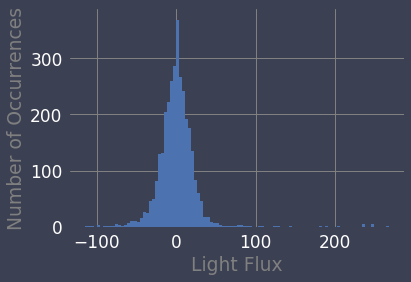

In [13]:
for i in range(7):
    plt.hist(remove_trend(exo1.iloc[i], 41), bins=100)
    plt.xlabel('Light Flux')
    plt.ylabel('Number of Occurrences')
    plt.show();

The data follows a normal distribution

In [14]:
def norm_bracketing(data):
    sigma = np.std(data)
    data = list(map(lambda x: 0 if x < 1*sigma else x, data))
    data = list(map(lambda x: 0.67 if 0 < x < 2*sigma else x, data))
    data = list(map(lambda x: 0.955 if 0.67 < x < 3*sigma else x, data))
    data = list(map(lambda x: 1 if x > 0.955 else x, data))
    return data

The `norm_bracketing` function relevels the values based on standard deviations

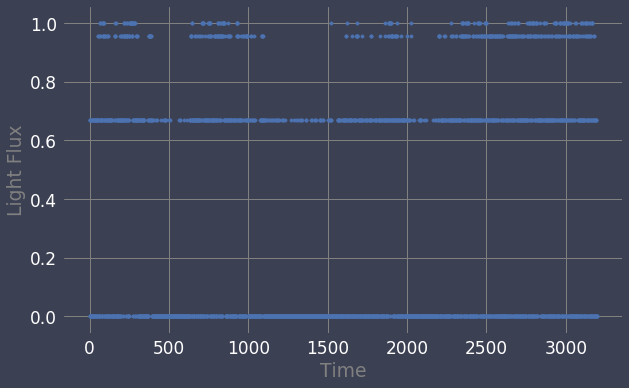

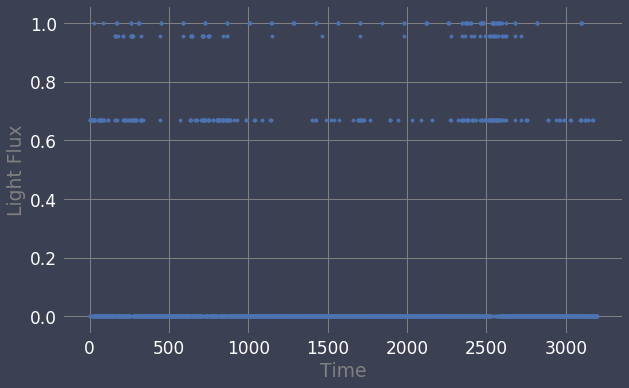

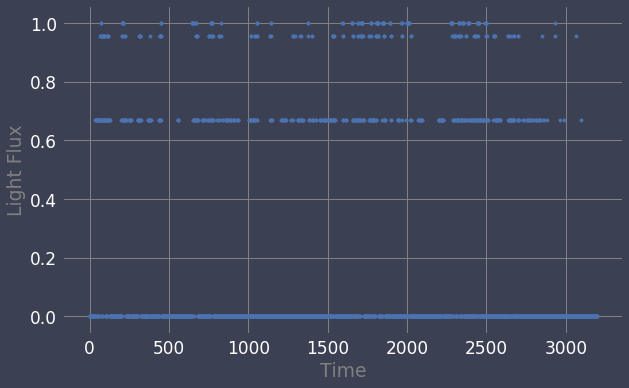

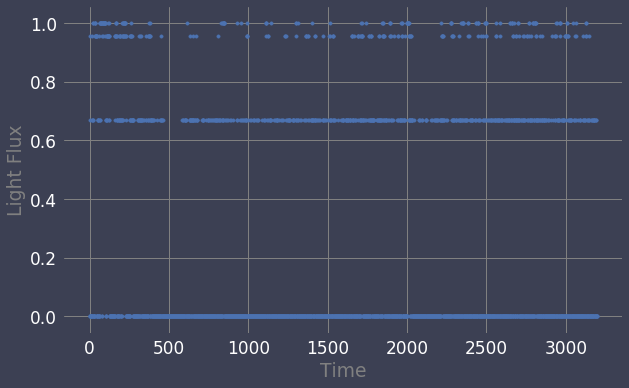

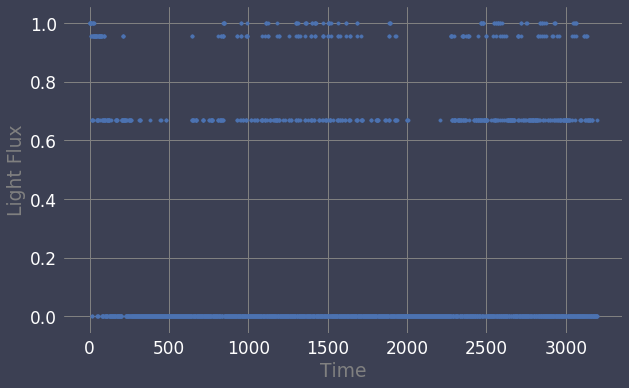

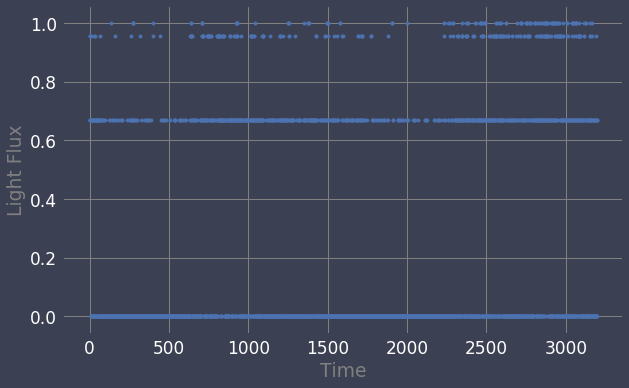

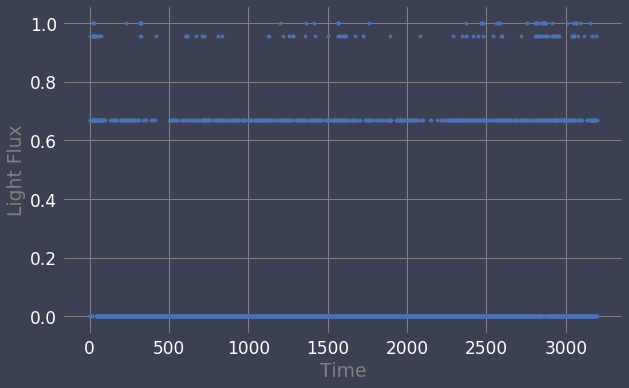

In [15]:
for i in range(7):
    data = np.abs(remove_trend(exo1.iloc[i], 41))
    plot_star(norm_bracketing(data))

These feature engineering is a step in the right direction. 

The variance can **widly change** within the data. Let's fight that by partitioning the data into bins, and then apply `normal_bracketing` to each bin.

In [16]:
def norm_bracketing(data, bins=30):
    data = np.array(data)
    div_length = int(len(data) / bins)
    count = 0
    while count <= bins:
        index = list(range(div_length*count, div_length*(count + 1)))
        try:
            sigma = np.std(data[index])
        except:
            index = list(range(div_length*count, len(data)))
            sigma = np.std(data[index])
        temp = list(map(lambda x: 0 if x < 1*sigma else x, data[index]))
        temp = list(map(lambda x: 0.67 if 0 < x < 2*sigma else x, temp))
        temp = list(map(lambda x: 0.95 if 0.67 < x < 3*sigma else x, temp))
        temp = list(map(lambda x: 0.99 if 0.95 < x < 4*sigma else x, temp))
        data[index] = list(map(lambda x: 1 if x > 0.99 else x, temp))
        count += 1
    return np.array(data)

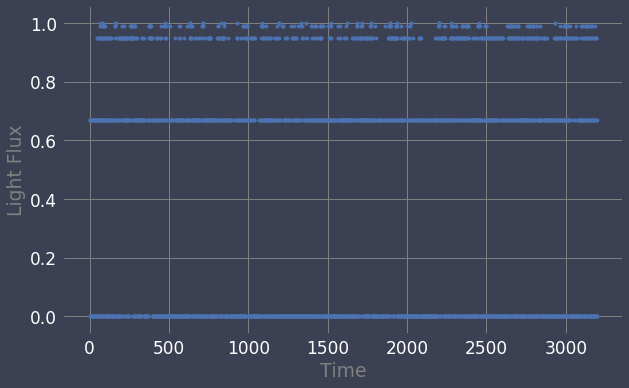

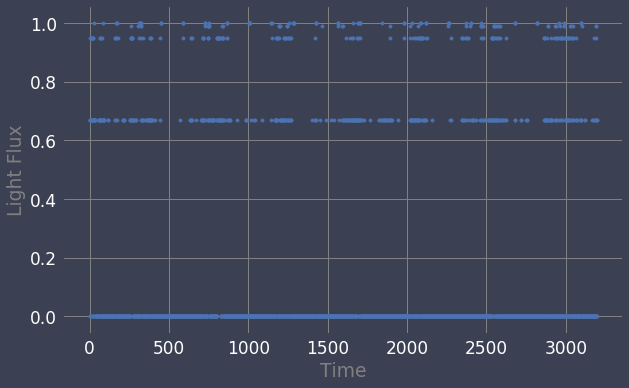

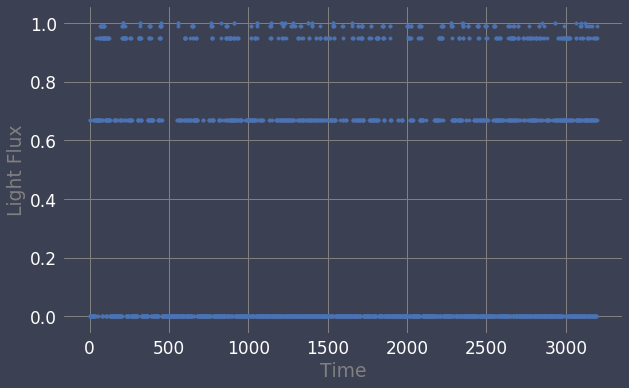

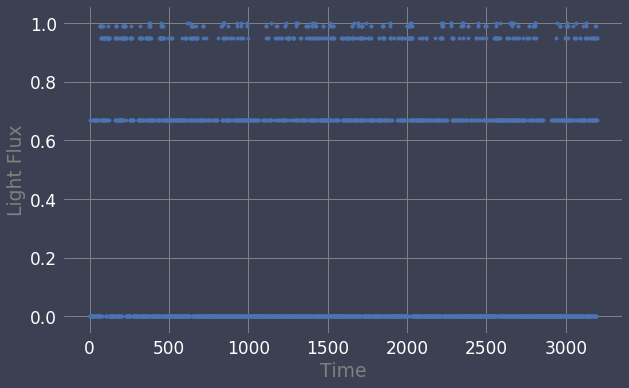

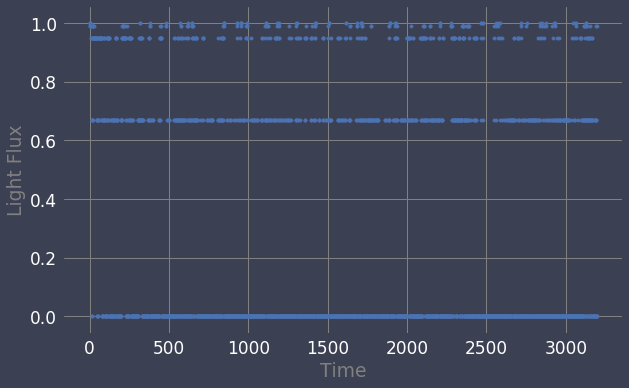

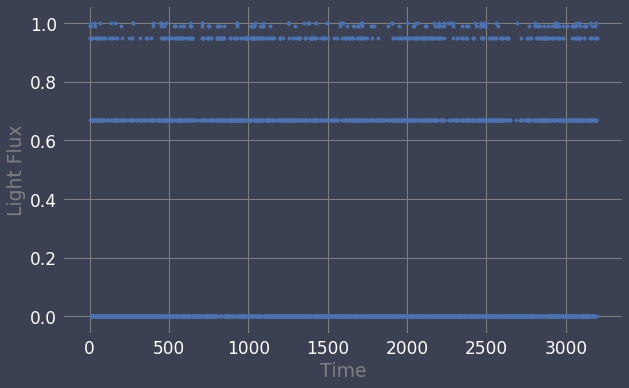

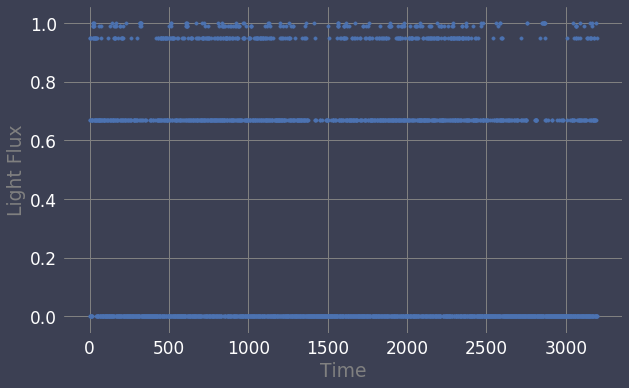

In [17]:
for i in range(7):
    data = np.abs(remove_trend(exo1.iloc[i], 41))
    plot_star(norm_bracketing(data, 30))

This helps elimate the varying variance (pun)

### Data Preprocessing

In [18]:
def cleaning_pipe(data, window=41, bins=20):
    cleaned = remove_trend(data, window)
    cleaned = np.abs(cleaned)
    cleaned = norm_bracketing(cleaned, bins)
    return cleaned

Cleaning data with exoplanets

In [19]:
data = None
for i in range(1,6):
    data = pd.concat([data,
                      pd.read_csv('./data/train_{}.csv'.format(i)).set_index('Unnamed: 0')])
data.index.rename('STAR', inplace=True)

In [30]:
temp = data.drop('LABEL', axis=1)
X = pd.DataFrame(np.zeros(temp.shape), columns=temp.columns)
for row in range(temp.shape[0]):
    if row % 100 == 0:
        print(row)
    X.iloc[row] = cleaning_pipe(temp.iloc[i])    # Independent variable
y = data['LABEL'] - 1    # Dependent variable

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


Random resample to balance classes

In [ ]:
ros = RandomOverSampler(random_state=13)
Xr, yr = ros.fit_sample(X, y) 

In [ ]:
for i in range(37):
    plot_star(X.iloc[i])

In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
for i in range(37):
#     fig, ax = plt.subplots(figsize=(12,5))
#     plot_acf(data.iloc[i], lags=500, ax=ax, color='#00CCFF')
#     plt.show()

### Modeling

### Data Preprocessing Pipeline

In [ ]:
# # Remove outliers
# def remove_outliers(data):
#     # Removes top and bottom 1% of data
#     data_sorted = sorted(data)
#     threshold = int(0.01 * len(data))
#     top = data_sorted[len(data) - threshold]
#     bottom = data_sorted[threshold]
#     return list(map(lambda x: 0 if (x > top or x < bottom) else x, data))

In [ ]:
# # Set all positive (+) light flux values to zero
# # Why? We're looking for dips, not brusts of brightness
# def lower_half(data):
#     return list(map(lambda x: 0 if x > 0 else x, data))

In [ ]:
# # Push data points to ones or zeros based on threshold
# def binarize(data, thres):
#     mx = max(data)
#     return list(map(lambda x: 0 if x > thres * mx else 1, data))

In [ ]:
# # Pipeline
# ss = StandardScaler()
# def pipe(data, window, thres):
#     data = remove_trend(exo1.iloc[i], window)
#     data = remove_outliers(data)
#     data = np.array(lower_half(data))
#     data = ss.fit_transform(data.reshape(-1, 1))
#     data = binarize(data, thres)
#     return data